In [16]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patheffects as path_effects
from shapely.geometry import Point, mapping
import rasterio
from rasterio.mask import mask
from matplotlib.patches import Patch
import seaborn as sns

# Calculate Rankings for each buffer

## Import Volcano Catalogue and Population Density Layer and reproject coordinates

In [35]:
volcano_data = pd.read_csv("Data_Inputs/CH_NVP_List_28Aug.csv")

volcano_df = pd.DataFrame(volcano_data)

volcano_gdf = gpd.GeoDataFrame(
    volcano_df, 
    geometry=gpd.points_from_xy(volcano_df["LON_CENTRE"], volcano_df["LAT_CENTRE"]),
    crs="EPSG:4326"
)


In [36]:
density_raster = rasterio.open("Data_Inputs/Density_Raster.gpkg")
density_nodata = density_raster.nodata

if volcano_gdf.crs != density_raster.crs:
    volcano_gdf = volcano_gdf.to_crs(density_raster.crs)


## Create buffer zones

In [37]:

volcano_gdf["buffer_5km"]  = volcano_gdf.geometry.buffer(5000)
volcano_gdf["buffer_10km"] = volcano_gdf.geometry.buffer(10000)
volcano_gdf["buffer_25km"] = volcano_gdf.geometry.buffer(25000)
volcano_gdf["buffer_50km"] = volcano_gdf.geometry.buffer(50000)
volcano_gdf["buffer_100km"] = volcano_gdf.geometry.buffer(100000)

volcano_gdf["zone_0_5"] = volcano_gdf["buffer_5km"]
volcano_gdf["zone_5_10"] = volcano_gdf["buffer_10km"].difference(volcano_gdf["buffer_5km"])
volcano_gdf["zone_10_25"] = volcano_gdf["buffer_25km"].difference(volcano_gdf["buffer_10km"])
volcano_gdf["zone_25_50"] = volcano_gdf["buffer_50km"].difference(volcano_gdf["buffer_25km"])
volcano_gdf["zone_50_100"] = volcano_gdf["buffer_100km"].difference(volcano_gdf["buffer_50km"])

## Create a function to get buffer zone metrics

In [39]:
def get_zone_metrics(polygon, raster, nodata):

    if not polygon.is_valid:
        polygon = polygon.buffer(0)
    if polygon.is_empty:
        return None, None

    if polygon.geom_type == 'MultiPolygon':
        shapes = [mapping(geom) for geom in polygon.geoms]
    else:
        shapes = [mapping(polygon)]
    
    try:
        out_image, out_transform = mask(dataset=raster, shapes=shapes, crop=True)
    except Exception as e:
        print("Error during masking for polygon:", e)
        return None, None

    if out_image is None or out_image.shape[0] == 0:
        return None, None
    try:
        data = out_image[0] 
    except IndexError as e:
        print("Error indexing the output image:", e)
        return None, None


    if nodata is not None:
        data = np.where(data == nodata, np.nan, data)
    
    if np.all(np.isnan(data)):
        avg_density = np.nan
    else:
        avg_density = np.nanmean(data)
    
    # Calculate area: pixel_area * number of valid pixels.
    pixel_area_m2 = abs(out_transform.a * out_transform.e)
    valid_pixel_count = np.count_nonzero(~np.isnan(data))
    pixel_area_km2 = pixel_area_m2 / 1e6
    zone_area_km2 = valid_pixel_count * pixel_area_km2
    return zone_area_km2, avg_density


## Create Function to Determine Ranking for each zone based on Average Density

In [51]:
def get_ranking_for_zone(zone, avg_density):

    if zone == "0_5":  # Within 5km buffer:
        if avg_density > 29.8:
            return 5   # Very High
        else:
            return 4   # High
    elif zone == "5_10":  # 5 to 10km buffer:
        if avg_density > 1194.65:
            return 5   # Very High
        elif avg_density > 3.6:
            return 4 #High
        else:
            return 3   # Moderate
    elif zone == "10_25":  # 10 to 25km buffer:
        if avg_density > 1194.65:
            return 4   # High
        elif avg_density > 3.6:
            return 3   # Moderate
        else:
            return 2   # Low
    elif zone == "25_50":  #25 to 50km buffer:
        if avg_density > 1194.65:
            return 4   # High
        elif avg_density > 29.8:
            return 3   # Moderate
        else:
            return 2   # Low

    elif zone == "50_100":  #50 to 100km buffer:
        if avg_density > 1194.65:
            return 3   #Moderate
        elif avg_density > 29.9:
            return 2 #Low
        else:
            return 1  #Very Low

    else:
        return 1


## Loop Over Volcanoes to Compute Metrics 

In [41]:
results = []
for idx, row in volcano_gdf.iterrows():
    name = row["Volcanic Centre Name"]
    

    zone0_5_poly = row["zone_0_5"]
    zone5_10_poly = row["zone_5_10"]
    zone10_25_poly = row["zone_10_25"]
    zone25_50_poly = row["zone_25_50"]
    zone50_100_poly = row["zone_50_100"]
    

    area_0_5, dens_0_5 = get_zone_metrics(zone0_5_poly, density_raster, density_nodata)
    area_5_10, dens_5_10 = get_zone_metrics(zone5_10_poly, density_raster, density_nodata)
    area_10_25, dens_10_25 = get_zone_metrics(zone10_25_poly, density_raster, density_nodata)
    area_25_50, dens_25_50 = get_zone_metrics(zone25_50_poly, density_raster, density_nodata)
    area_50_100, dens_50_100 = get_zone_metrics(zone50_100_poly, density_raster, density_nodata)
    

    if (area_0_5 is None or dens_0_5 is None or 
        area_5_10 is None or dens_5_10 is None or 
        area_10_25 is None or dens_10_25 is None or
        area_25_50 is None or dens_25_50 is None or
        area_50_100 is None or dens_50_100 is None):
        print(f"Skipping {name} due to missing zone metrics.")
        continue


    rank_0_5 = get_ranking_for_zone("0_5", dens_0_5)
    rank_5_10 = get_ranking_for_zone("5_10", dens_5_10)
    rank_10_25 = get_ranking_for_zone("10_25", dens_10_25)
    rank_25_50 = get_ranking_for_zone("25_50", dens_25_50)
    rank_50_100 = get_ranking_for_zone("50_100", dens_50_100)


    results.append({
        "Volcanic Centre Name": name,
        "Area_0_5_km2": area_0_5,
        "Avg_Density_0_5": dens_0_5,
        "Ranking_0_5": rank_0_5,
        "Area_5_10_km2": area_5_10,
        "Avg_Density_5_10": dens_5_10,
        "Ranking_5_10": rank_5_10,
        "Area_10_25_km2": area_10_25,
        "Avg_Density_10_25": dens_10_25,
        "Ranking_10_25": rank_10_25,
        "Area_25_50_km2": area_25_50,
        "Avg_Density_25_50": dens_25_50,
        "Ranking_25_50": rank_25_50,
        "Area_50_100_km2": area_50_100,
        "Avg_Density_50_100": dens_50_100,
        "Ranking_50_100": rank_50_100,
    })



results_df = pd.DataFrame(results)



# Pareto Calculation

## Define Helper Functions

In [42]:
def dominates(a, b):

    ge = all(x >= y for x, y in zip(a, b))
    gt = any(x > y   for x, y in zip(a, b))
    return ge and gt

def pareto_fronts(points):

    N = len(points)
    front_no = [0]*N
    remaining = set(range(N))
    current = 1

    while remaining:
        front = []
        for i in remaining:

            if all(not dominates(points[j], points[i]) for j in remaining if j != i):
                front.append(i)

        for i in front:
            front_no[i] = current
            remaining.remove(i)
        current += 1

    return front_no

## Build list of rank-tuples

In [43]:
rank_cols = [
    "Ranking_0_5",
    "Ranking_5_10",
    "Ranking_10_25",
    "Ranking_25_50",
    "Ranking_50_100",
]
points = results_df[rank_cols].values.tolist()
results_df["Exposure_Pareto_Front"] = pareto_fronts(points)


## Assigning each volcano a front number and export

In [44]:
fronts = results_df["Exposure_Pareto_Front"]


F = fronts.max()   


edges = np.linspace(1, F+1, num=10)  

coords_df = volcano_gdf[["Volcanic Centre Name","LAT_CENTRE","LON_CENTRE"]]

final = results_df.merge(
    coords_df,
    on="Volcanic Centre Name",
    how="left"
)


first_col = "Volcanic Centre Name"
lat_col   = "LAT_CENTRE"
lon_col   = "LON_CENTRE"


other_cols = [c for c in final.columns 
              if c not in (first_col, lat_col, lon_col)]
new_order  = [first_col, lat_col, lon_col] + other_cols

final = final[new_order]


final.to_csv("DataMap_Outputs/Pareto_Output_CH.csv", index=False)

# Mapping data

## Import data

In [19]:
PDmatrix = pd.read_csv("DataMap_Outputs/Pareto_Output_CH.csv")
LGAS= gpd.read_file("NVP_Locations/LGAS_Decile.gpkg")
colac_lin = gpd.read_file("NVP_Locations/colac_lineament.gpkg")
shapefile = gpd.read_file("Aus_Shapefile/STE_2021_AUST_GDA2020.shp")
CH = gpd.read_file("NVP_Locations/subProvincesAndRegions.gdb", layer="CentralHighlands")


In [20]:
Pareto = PDmatrix["Exposure_Pareto_Front"]
PDmatrix["Exposure_Pareto_Front"] = (
    PDmatrix["Exposure_Pareto_Front"]
    .fillna(5)    # default lowest
    .astype(int)
)

In [21]:
PDmatrix["geometry"] = PDmatrix.apply(lambda row: Point(row["LON_CENTRE"], row["LAT_CENTRE"]), axis=1)
gdf = gpd.GeoDataFrame(PDmatrix, geometry="geometry", crs="EPSG:4326")

In [22]:
LGAS = LGAS.to_crs(gdf.crs)
colac_lin = colac_lin.to_crs(gdf.crs)
shapefile = shapefile.to_crs(gdf.crs)
CH = CH.to_crs(gdf.crs)

In [23]:
CH_proxy = Patch(facecolor='#ef78ff', edgecolor='#b102c9', label='Central Highlands Subprovince')
handles = [CH_proxy]

## Create colour ramp

In [24]:
ranking_labels = list(range(1,6))
color_map = {
    5: "#2b83ba",
    4: "#abdda4", 
    3: "#ffffbf",  
    2: "#fdae61",       
    1: "#d7191c"
           
    
}
PDmatrix["color"] = PDmatrix["Exposure_Pareto_Front"].map(color_map)
colors = PDmatrix["color"].tolist()
color_list = [ color_map[i] for i in ranking_labels ]
cmap       = ListedColormap(color_list)
norm = Normalize(vmin=1, vmax=5)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 

## Plot data

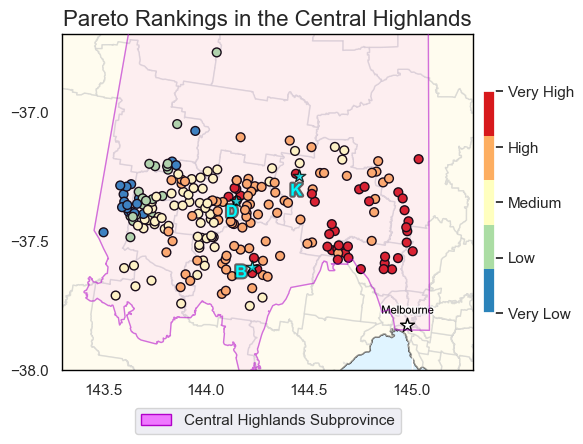

In [27]:
fig, ax = plt.subplots()
LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
CH.plot(ax=ax, color='#ef78ff', edgecolor='#b102c9', alpha=0.1, zorder=2)
CH.plot(ax=ax, facecolor='none', edgecolor='#b102c9', zorder=4, alpha=0.5)

gdf.plot(
    ax         = ax,
    column     = "Exposure_Pareto_Front",
    cmap       = ListedColormap(color_list),  
    markersize = 40,
    edgecolor  = "black",
    norm       = norm,                    
    zorder     = 1
)


ax.scatter(144.97806, -37.8240, facecolor='white', edgecolor='black', zorder=3, marker='*',  s=110) #Melbourne
ax.scatter(144.14665, -37.34414,color='#03f8fc', edgecolor='black', zorder=2, alpha=0.8, s=90, marker='*') #Daylesford
ax.scatter(144.22288, -37.60136,color='#03f8fc', edgecolor='black', zorder=2, s=90, alpha=0.8, marker='*') #Ballan
ax.scatter(144.45361, -37.24717,color='#03f8fc', edgecolor='black', zorder=2, s=90, alpha=0.8, marker='*') #Kyneton

Daylesford = ax.annotate(
    'D',          
    xy=(144.14665, -37.34414),              
    xytext=(144.1259,-37.4062), 
    fontsize=12,
    color='#03f8fc', fontweight='bold',
    ha="center"
)
Daylesford.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(0,0,0, 0.6)),
    path_effects.Normal()
    ])

Kyneton = ax.annotate(
    'K',          
    xy=(144.45361, -37.24717),              
    xytext=(144.4384,-37.3241),
    fontsize=12,
    color='#03f8fc',fontweight='bold',
    ha="center"
)
Kyneton.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(0,0,0, 0.6)),
    path_effects.Normal()
    ])

Ballan = ax.annotate(
    'B',          
    xy=(144.22288, -37.60136),              
    xytext=(144.1710, -37.64),          
    fontsize=12,
    color='#03f8fc',fontweight='bold',
    ha="center"
)
Ballan.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(0,0,0, 0.6)),
    path_effects.Normal()
    ])


Melbourne = ax.annotate(
    'Melbourne',          
    xy=(144.97806, -37.8240),              
    xytext=(144.98, -37.78),          
    fontsize=8,
    color='black',
    ha="center"
)
Melbourne.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(1, 1, 1, 0.6)),
    path_effects.Normal()
    ])


cbar = fig.colorbar(
    sm,
    ax     = ax,
    ticks  = [1,2,3,4,5],
    shrink = 0.6,
    pad    = 0.02
)


cbar.ax.set_yticklabels([
    "Very High",
    "High",
    "Medium",
    "Low",
    "Very Low"
])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor("black")


cbar.ax.invert_yaxis()

ax.legend(handles=handles, frameon=True,loc='center',bbox_to_anchor=(0.5,-0.15), ncol=3)

ax.set_facecolor('#e0f4ff')
ax.set_xlim(143.3, 145.3)
ax.set_ylim(-38,-36.7)
ax.set_xticks([143.5, 144, 144.5, 145])
ax.set_yticks([-37, -37.5, -38])

ax.set_title("Pareto Rankings in the Central Highlands", fontsize=16)
plt.savefig("DataMap_Outputs/paretomapch.png", dpi=600)
plt.show()

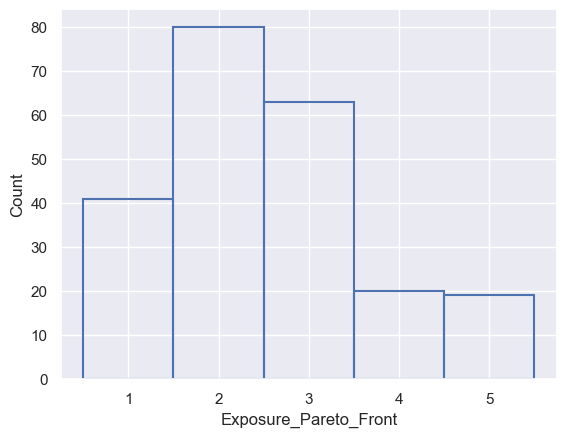

In [14]:
sns.set_theme(style="darkgrid")
ax = sns.histplot(data=Pareto, fill=False, discrete=True)
plt.savefig("DataMap_Outputs/paretodistributionch.png", dpi=600)